# Implementation of TOME in Python

Here is an implementation of TOME in Python. Proof of this being eqiuvalent to TOME can be seen in Valdiation???.

The main reasson to implement TOME in Python is to define down-stream analysis functions in order to show that the basic KNN approach is not able to create a realistic link between cells of different time points. This was never claimed by Qiu et al., however Moscot does claim to provide this and it will be shown that Moscot is able to represent the transitions more realisticly. 

In [1]:
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import os
import scanpy as sc
import sklearn.metrics
import seaborn as sns
import scipy

import matplotlib
from scipy.spatial import cKDTree

sc.settings.verbosity = 0

In [2]:
Path="/home/icb/manuel.gander/Reproducibility_TOME/Data"

# Define time points
t=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[8.5]+[9.5+x for x in range(0,5)]
ts=[str(a) for a in [3.5, 4.5, 5.25, 5.5, 6.25]] + [str(a) for a in np.arange(6.5, 8.5, 0.25)] + ['8.5a', '8.5b']+ [str(a) for a in np.arange(9.5, 14.5, 1)]
ts=['E'+a for a in ts]

t2=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[9.5+x for x in range(0,5)]

# These are the estimated amount of cells in the whole embryo for each time point (provided by TOME, see http://tome.gs.washington.edu/
cells=[32, 80, 100, 120, 400, 660, 1720, 4500, 8200, 15000, 30000, 60000, 73000, 90000, 200000, 1100000, 2600000, 6000000, 13000000 ]

# Average growth rates for each time pair

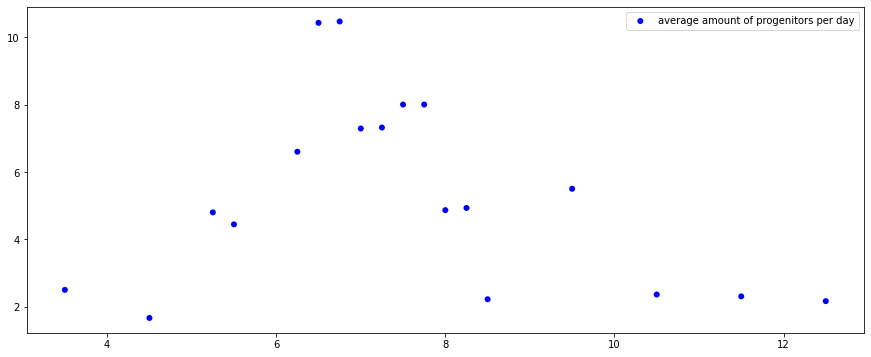

In [3]:
av_g=np.ones(len(t2)-1)
for i in range(0,len(av_g)):
    av_g[i]=cells[i+1]/cells[i]/(t2[i+1]-t2[i])
        
fig = plt.figure()
ax = plt.gca()
fig.set_size_inches(15, 6)
ax.scatter(t2[:-1], av_g, c='blue', alpha=1, edgecolors='none', label='average amount of progenitors per day')
plt.legend(loc="upper right")

# Utils

In [4]:
# Load and prepare anndatas
def load_adata(ts0, ts1):
    # Load the adata
    
    A0=sc.read(f"{Path}/anndatas/adata_{ts0}.h5ad")
    A0.obs['stage']=ts0
    A1=sc.read(f"{Path}/anndatas/adata_{ts1}.h5ad")
    A1.obs['stage']=ts1
    
    adata=A0.concatenate(A1, join='outer', index_unique=None, batch_key=None)
    
    # Load the representation from Seurat-integration
    PCA=pd.read_csv(f"{Path}/Seurat_Representations/{ts0}_{ts1}_pca.csv", sep= ",")
    adata.obsm['X_pcaS']=PCA.to_numpy()[:,1:]
    adata.obsm['X_pcaS']=np.array(adata.obsm['X_pcaS'], dtype=np.float32)

    UMAP=pd.read_csv(f"{Path}/Seurat_Representations/{ts0}_{ts1}_umap3.csv", sep= ",")
    adata.obsm['X_umap3']=UMAP.to_numpy()[:,1:]
    adata.obsm['X_umap3']=np.array(adata.obsm['X_umap3'], dtype=np.float32)
    
    # Check if cells are ordered the same in adata as they are in the Seurat-representation, if not, reorder
    B=[a for a in PCA['Unnamed: 0']]
    A=[a for a in adata.obs_names]
    if A!=B:
        print('Reordering...')
        Dict={}
        for ii in range(0,len(A)):
            Dict[B[ii]]=ii
        PCA2=adata.obsm['X_pcaS'].copy()
        B2=B.copy()
        for ii in range(0,len(A)):
            PCA2[ii,:]=adata.obsm['X_pcaS'][Dict[A[ii]],:].copy()
            B2[ii]=B[Dict[A[ii]]]
        if A!=B2:
            print('Cell re-ordering was not succesful')
        else:
            adata.obsm['X_pcaS']=PCA2
            print('Done')
        
    A0=adata[adata.obs['stage']==ts0].copy()
    A1=adata[adata.obs['stage']==ts1].copy()
    A0.obs['arange']=np.arange(len(A0))
    A1.obs['arange']=np.arange(len(A1))

    return(A0, A1)

# Function to determine the k nearest neighbors of two distinct data sets in the respectively other data set.
# Additionally, a fraction of cells can be removed from one data set.

def knn_p(M, A0, A1, k, nn, seed, removing_cells_ratio):
    
    ar=np.arange(len(A0))
    np.random.seed(seed)
    np.random.shuffle(ar)
    
    removed=ar[:int(len(ar)*removing_cells_ratio)]    
    z=np.zeros(len(A0))
    for i in removed:
        z[i]=1
    
    T=np.zeros((len(A1),k))
    
    for m in range(len(A1)):
        # The nn neirest neighbors, but we only want to keep the not-removed ones
        arr=M[m,:]
        
        # This is going to be the k closest nn of the subsampled A1
        ind=np.zeros(k)

        s=0
        n=0
        # if the k-neirest neighobrs from t0 are in the  closest
        while s<k and n<nn:
            if z[arr[n]]==1:
                n+=1
            else:
                ind[s]=arr[n]
                s+=1
                n+=1
        
        # if not enough could be found (extremly unlikely) brute force it:

        if n==nn:
            print('brute forced')
            # Construct A0s
            bo=np.zeros(len(A0))
            
            inside=ar[int(len(ar)*removing_cells_ratio):]

            for i in inside:
                bo[i]=1
            bo=np.array(bo, dtype=bool)
            A0s=A0[bo].copy()

            # Calculate distance and take k closest neighbors
            v=sklearn.metrics.pairwise_distances(A1.obsm['X_umap3'][m].reshape(1, -1), A0s.obsm['X_umap3'])[0]
            ind=np.argpartition(v, k)[:k]
        
        T[m,:]=ind.copy()
            
    return(T)

# Transform the knn-array to cellular growth rates
def Ts_to_gr(Ts, lt, sel=None):
    
    (l,k)=Ts[0].shape
    
    # lt=length of target
    G=np.zeros((len(Ts),lt))

    for d in Ts.keys():
        g=np.zeros(lt)

        A=Ts[d]
        
        if sel==None:
            for m in range(l):
                for ks in range(k):
                    g[int(A[m,ks])]+=1
        else:
            for m in sel:
                for ks in range(k):
                    g[int(A[m,ks])]+=1
        
        G[d,:]=g
                    
    return(G)

# Transform the knn-array to cell type transitions
def Ts_to_A(Ts, Source, Target, replication_times, mode='median'):
    
    (l,k)=Ts[0].shape
    
    # Get cell types
    
    Target.obs['cell_state']=Target.obs['cell_state'].astype('category')
    Source.obs['cell_state']=Source.obs['cell_state'].astype('category')

    
    par=Target.obs['cell_state'].cat.categories
    chi=Source.obs['cell_state'].cat.categories
    Cs0=Source.obs['cell_state']
    Cs1=Target.obs['cell_state']

    D_par={}
    for j in range(len(par)):
        D_par[par[j]]=j
    D_chi={}
    for j in range(len(chi)):
        D_chi[chi[j]]=j

    DA={}
    for reps in range(replication_times+1):
        A=anndata.AnnData(X=np.zeros((len(chi), len(par)), dtype=np.float32))
        A.var['cell_state_parent']=[a for a in par]
        A.obs['cell_state_child']=[a for a in chi]  
        DA[reps]=A

    for a in chi:
        Aa=Source[Source.obs['cell_state']==a]
        sel=[a for a in Aa.obs['arange']]
        lt=len(Target)
        G=Ts_to_gr(Ts, lt, sel=sel)
        
        for reps in range(replication_times):
            gn=G[reps,:]
            gn=gn/gn.sum()
            for b in par:
                z=np.array(Cs1==b, dtype=float)
                DA[reps].X[D_chi[a],D_par[b]]=np.matmul(gn,z.T)
    
    
    for a in chi:
        for b in par:
            v=np.zeros(replication_times)
            for reps in range(replication_times):
                v[reps]=DA[reps].X[D_chi[a],D_par[b]]
            
            if mode=='mean':
                val=v.mean()
            elif mode=='median':
                val=np.median(v)
                
                            
            DA[replication_times].X[D_chi[a],D_par[b]]=val
            
        vec=DA[replication_times].X[D_chi[a],:]
        vec=vec/vec.sum()
        DA[replication_times].X[D_chi[a],:]=vec
        
    
    return(DA[replication_times])

------------------------------------------------------------------------
E3.5


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


                                
     
Percentage of cells without progenitor: 45.92669983416253%


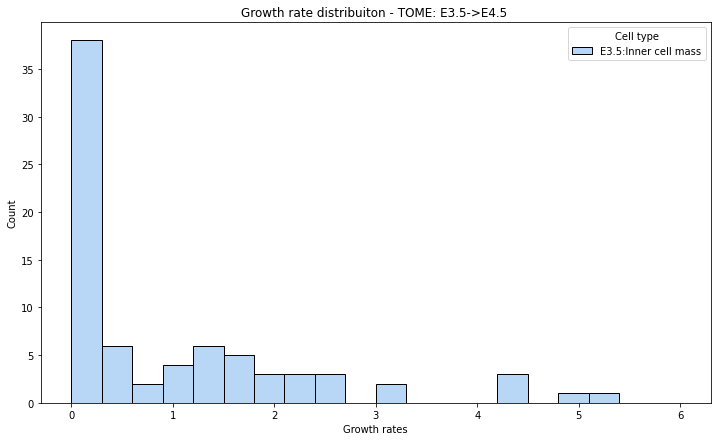

------------------------------------------------------------------------
E4.5


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Reordering...
Done
                                
     
Percentage of cells without progenitor: 45.07255039004374%


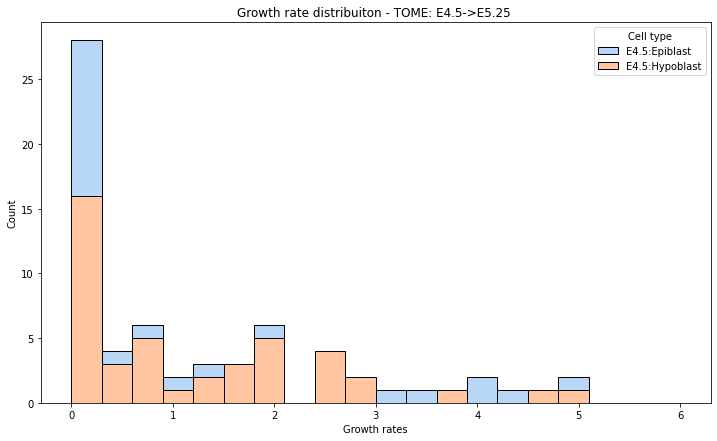

------------------------------------------------------------------------
E5.25


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Reordering...
Done
                                
     
Percentage of cells without progenitor: 42.65827950828213%


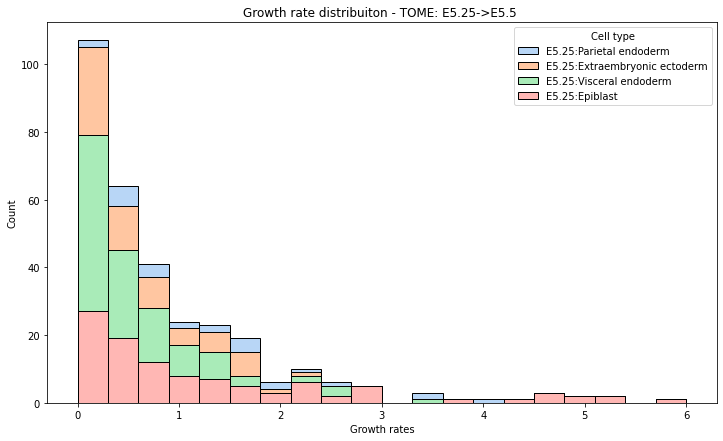

------------------------------------------------------------------------
E5.5


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Reordering...
Done
                                
     
Percentage of cells without progenitor: 39.59744870555376%


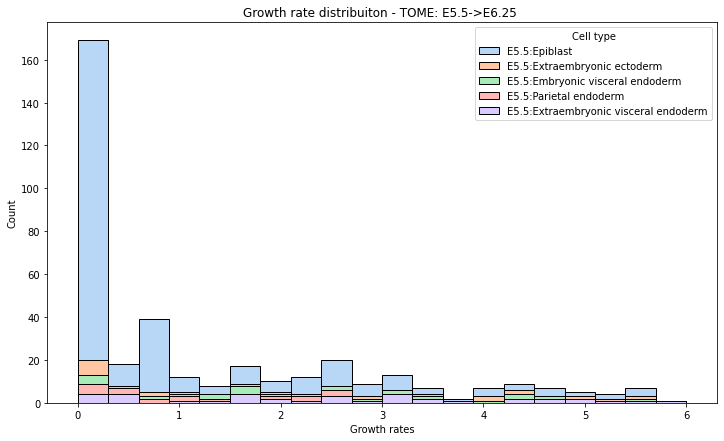

------------------------------------------------------------------------
E6.25


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Reordering...
Done
                                
     
Percentage of cells without progenitor: 30.20340427500694%


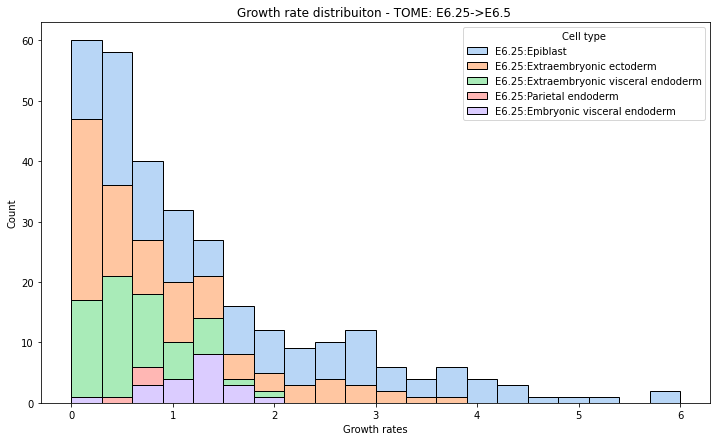

------------------------------------------------------------------------
E6.5


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Reordering...
Done
                                
     
Percentage of cells without progenitor: 41.053455248175425%


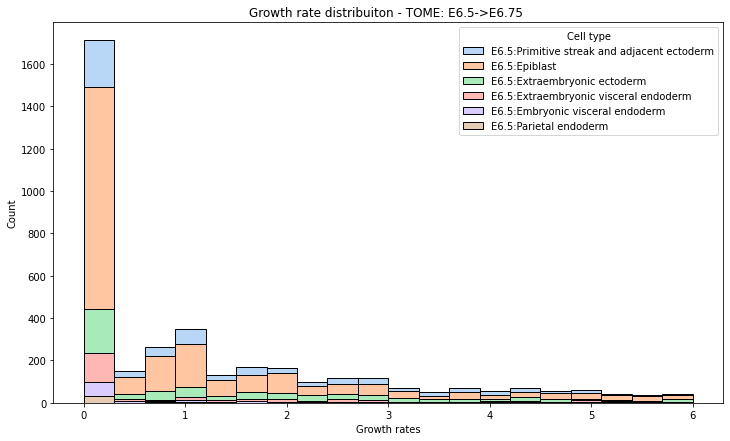

------------------------------------------------------------------------
E6.75


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


                                
     
Percentage of cells without progenitor: 7.893567132057004%


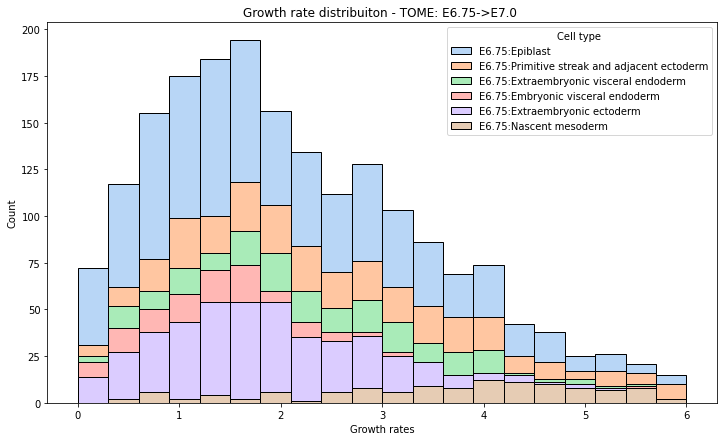

------------------------------------------------------------------------
E7.0


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


                                
     
Percentage of cells without progenitor: 23.51345078385138%


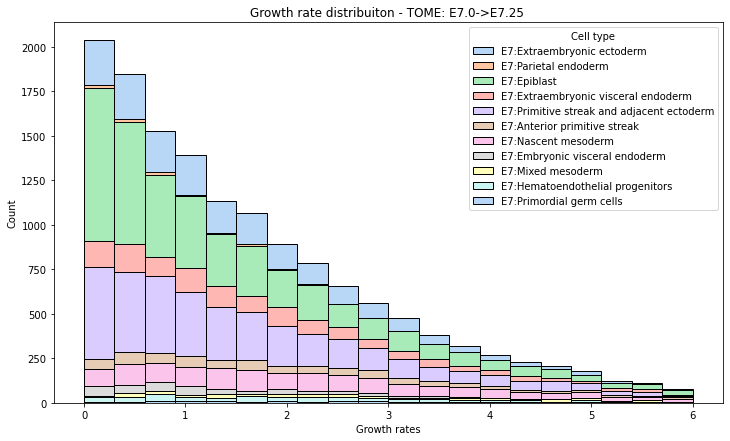

In [5]:
replication_times=500
removing_cells_ratio=0.2
nn=30
k=5

for i in range(8):
    ts0=ts[i]
    print('------------------------------------------------------------------------')
    print(ts0)

    ts1=ts[i+1]

    (A0,  A1)=load_adata(ts0, ts1)

    Source=A1
    Target=A0
    Cst=Target.obs['cell_state']

    ls=len(Source)
    lt=len(Target)
    M=cKDTree(Target.obsm['X_pcaS']).query(Source.obsm['X_pcaS'], k=20, workers=4)[1]


    Ts={}
    for reps in range(replication_times):
        Ts[reps]=knn_p(M, Target, Source, k, nn, reps, removing_cells_ratio)


    G=Ts_to_gr(Ts, lt)
    A=Ts_to_A(Ts, Source, Target, replication_times)

    g=G.sum(axis=0)
    g=g/g.mean()

    if ts0=='E8.5a':
        t0=0
        t1=1
    else:
        t0=t[i]
        t1=t[i+1]

    if ts[i]=='E8.5a':
        g=g/g.mean()
    elif i>13:
        g=g/g.mean()*av_g[i-1]*(t1-t0)
    else:
        g=g/g.mean()*av_g[i]*(t1-t0)

    df=pd.DataFrame({'growth_rates':g, 'Cell type':Cst})
    f = plt.figure(figsize=(12,7))
    ax = f.add_subplot(1,1,1)

    sns.histplot(data=df, ax=ax,  multiple="stack", x="growth_rates", hue='Cell type', bins=20, kde=False, binrange=[0,6], palette="pastel",legend=True)
    ax.set_title(f"Growth rate distribuiton - TOME: {ts0}->{ts1} ")
    ax.set_xlabel("Growth rates")
    ax.set_ylabel("Count")

    ap_w=0
    for j in range(len(g)):
        if g[j]<1:
            ap_w+=1-g[j]
    ap_w=ap_w/len(g)
    print('                                ')
    print('     ')
    print(f'Percentage of cells without progenitor: {ap_w*100}%')

    Dict={}
    Dict['A']=A
    Dict['g']=g
    Dict['ap_w']=ap_w

    np.save(f"{Path}/TOME-maps/Python_TOME_map_{ts0}_{ts1}_full_data.npy", Dict, allow_pickle=True)


    time.sleep(0.1)
    plt.pause(0.0001) 